# Importations et constantes

## Installations et importations des modules

In [0]:
!pip install -q keras

!pip install -q tqdm
from tqdm import tqdm
from tqdm import tqdm_notebook

import random as rd
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install -q panda
import pandas as pd
!pip install -q openpyxl
import tensorflow as tf
import timeit
from __future__ import print_function
from PIL import Image

In [0]:
#KERAS
import keras
from keras import activations, initializers, regularizers, constraints,metrics
from keras.legacy import interfaces
from keras.engine import InputSpec, Layer
from keras.layers import Input, BatchNormalization, concatenate, Reshape, Conv2DTranspose, Activation
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam, Adagrad
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.utils import np_utils
from keras.utils.generic_utils import func_dump, func_load, deserialize_keras_object


Using TensorFlow backend.


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive -v
!google-drive-ocamlfuse drive

In [0]:
"""
Quelques commandes pour Colab :

  - Installations :
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  - Creer un nouveau dossier :
!mkdir -p drive -v
(-p : creer aussi toute l'arborescence si elle n'existait pas, -v : verbosite)

  - Definir le chemin par defaut :
os.chdir("drive/app")

  - Mount Google drive :
!mkdir -p drive -v
!google-drive-ocamlfuse drive
Cette commande lie Colab et le drive. Les modifications dans l'un se retrouvent dans l'autre.

"""

## Constantes

In [0]:
#Bases de donnees :
#MNIST
nb_classes_MNIST = 10
dimensions_MNIST = (28,28,1)
#3Dchairs
nb_classes_3Dchairs = 1393
nb_images_par_classes_3Dchairs = 62
dimensions_3Dchairs = (64,64,3)

randomVectorSizeC = 10
randomVectorSize = 15

adagrad_1 = Adagrad(lr=0.001, epsilon=None, decay=0.0)
adagrad_2 = Adagrad(lr=0.001, epsilon=None, decay=0.0)

adam_1 = Adam(lr=0.0001, beta_1=0.5)  #par defaut pour le generateur et l'encodeur 
adam_2 = Adam(lr=0.000001, beta_1=0.5)  #par defaut pour le discriminateur

adam_3 = Adam(lr=0.0002, beta_1=0.5) #predicteur

## Importations des bases de données

In [0]:
#MNIST

from keras.datasets import mnist
# input image dimensions
img_rows, img_cols = 28, 28
nb_classes_MNIST =10

##### Chargement des donnees

# the data, shuffled and split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print (K.image_dim_ordering())

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train /127.5 -1
X_test = X_test /127.5 -1
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(Y_train, nb_classes_MNIST)
y_test = np_utils.to_categorical(Y_test, nb_classes_MNIST)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

# Fonctions

## Base de données

In [0]:
def faire_des_paires(bdd, new=True, nb_paires=0, X_train_2=[], X_train=X_train, Y_train=Y_train, test=False):
    
  if bdd == "MNIST":
    global nb_classes_MNIST
    nb_classes = nb_classes_MNIST
    global dimensions_MNIST
    dim = dimensions_MNIST
    if test:
      global X_test
      X_train = X_test
      global Y_test
      Y_train = Y_test
    X = []
    for n in range(nb_classes):
      X_0=X_train[np.where(Y_train==n)]
      X.append(X_0)

    if new:
      X_train_2 = np.zeros((nb_paires, 2, dim[0], dim[1], dim[2]))
    nb_paires = len(X_train_2)
    nb_paires_par_classes = int(nb_paires / nb_classes)
    for i in range(nb_paires_par_classes):
      for j in range(nb_classes):
        k1=rd.randint(0,len(X[j])-1)
        k2=rd.randint(0,len(X[j])-1)
        while k1==k2:
          k2=rd.randint(0,len(X[j])-1)
        img1=X[j][k1]
        img2=X[j][k2]
        X_train_2[nb_classes*i+j][0] = img1
        X_train_2[nb_classes*i+j][1] = img2
  
  elif bdd == "3Dchairs":
    global nb_classes_3Dchairs
    nb_classes = nb_classes_3Dchairs
    global nb_images_par_classes_3Dchairs
    nb_images_par_classes = nb_images_par_classes_3Dchairs
    global dimensions_3Dchairs
    dim = dimensions_3Dchairs
    if test:
      print("Pas de bdd de test pour 3Dchairs")
      print("Une bdd d'entrainement va etre generee")
    if new:
      X_train_2 = np.zeros((nb_paires, 2, dim[0], dim[1], dim[2]))
    path = "drive/"+bdd+"/chair"
    nb_paires = len(X_train_2)
    nb_folders = nb_classes
    nb_paires_par_classes = int(nb_paires / nb_classes)
    if nb_paires < nb_folders:
      nb_folders = nb_paires
      nb_paires_par_classes = 1
    f = 0
    c = 0
    for _ in tqdm(range(nb_folders)):
      for im in range(nb_paires_par_classes):
        k1=np.random.randint(0,nb_images_par_classes-1)
        k2=np.random.randint(0,nb_images_par_classes-1)
        while k1==k2:
          k2=rd.randint(0,nb_images_par_classes-1)

        name = path+str(f)+"/"
        name1 = name+str(k1)+".png"
        name2 = name+str(k2)+".png"
        X_train_2[nb_paires_par_classes*c+im] = [np.asarray(Image.open(name1)), np.asarray(Image.open(name2))]
      c += 1
      if nb_folders < nb_classes:
        f = np.random.randint(0, nb_classes-1)
      else: f = f + 1
    X_train_2 = (X_train_2 / float(127.5)) - 1 #pour normer entre -1 et 1
        
  #np.random.shuffle(X_train_2)
  return(X_train_2)

def bdd_pandas(bdd, nb_classes_par_panel):
  if bdd == "3Dchairs":
    
    #constantes
    global nb_classes_3Dchairs
    nb_classes = nb_classes_3Dchairs
    global nb_images_par_classes_3Dchairs
    nb_images_par_classes = nb_images_par_classes_3Dchairs
    global dimensions_3Dchairs
    dim = dimensions_3Dchairs

    nb_de_panels = int(nb_classes/float(nb_classes_par_panel))
    reste = nb_classes - nb_de_panels*nb_classes_par_panel
    if reste != 0:
      nb_de_panels +=1
      
    nb_total_images_par_panel = nb_images_par_classes*nb_classes_par_panel
    
    X_train = []
    
    #initialisation d'un panel
    data = np.random.rand(nb_total_images_par_panel*dim[2], dim[0], dim[1])
    p = pd.Panel(data)
    
    #pour chaque panel
    for j in range(nb_de_panels):
      print("Images de chair"+str(j*nb_classes_par_panel)+" a chair"+str(nb_classes_par_panel*(j+1)-1))
      
      if j == nb_de_panels - 1 and reste != 0:
        #pour chaque classe du panel
        i=0
        for _ in tqdm(range(reste)):
          path = "drive/3Dchairs/chair"+str(nb_classes_par_panel*j+i)+"/"

          #pour chaque image de la classe
          for k in range(nb_images_par_classes):
            name = path + str(k) + ".png"
            img = np.asarray(Image.open(name))
            img = img /127.5 -1

            #copie de tous les canaux de l'image
            for a in range(dim[2]):
              p[nb_images_par_classes*i+dim[2]*k+a] = img[:,:,a]
          i+=1
          
      else:
        #pour chaque classe du panel
        i=0
        for _ in tqdm(range(nb_classes_par_panel)):
          path = "drive/3Dchairs/chair"+str(nb_classes_par_panel*j+i)+"/"

          #pour chaque image de la classe
          for k in range(nb_images_par_classes):
            name = path + str(k) + ".png"
            img = np.asarray(Image.open(name))
            img = img /127.5 -1

            #copie de tous les canaux de l'image
            for a in range(dim[2]):
              p[nb_images_par_classes*i+dim[2]*k+a] = img[:,:,a]
          i+=1
      X_train.append(p)
    return(X_train)
        

## Modèles

In [0]:
def create_model(model, bdd, opt_G = adam_1, opt_D = adam_2, opt_P = adam_3, nb_sorties = 1, loss = 'mse'):
  #model="GMV" ou "CGMV" ; nb_sorties=1 ou 2
  
  if bdd == "MNIST":
    if model == "GMV" or model == "CGMV":
      # Generator
      g_input_c = Input(shape=(randomVectorSize,),name="g_input_c")
      g_input_v = Input(shape=(randomVectorSize,),name="g_input_v")
      x = concatenate([g_input_c,g_input_v])
      x = Dense(7*7*128) (x)
      x = Reshape((7,7,128)) (x)
      x = Conv2DTranspose(64,kernel_size=(5,5),strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
      #x = BatchNormalization() (x)
      x = Activation('relu') (x)
      #x = Dropout(0.3) (x)
      x = Conv2DTranspose(1,kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
      #x = BatchNormalization() (x)
      g_prediction = Activation('tanh') (x)

      generator = Model(input = [g_input_c,g_input_v], output = g_prediction)
      generator.compile(optimizer=opt_G, loss=loss)

      #Discriminateur    
      d_input_1 = Input(shape=(28,28,1),name="d_input_1")
      d_input_2 = Input(shape=(28,28,1),name="d_input_2")
      x = concatenate([d_input_1, d_input_2])
      x = Reshape((28,28,2)) (x)
      x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
      x = LeakyReLU(0.2)                                                 (x)
      #x = Dropout(0.3)                                                   (x)
      x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
      #x = BatchNormalization()                                           (x)
      x = LeakyReLU(0.2)                                                 (x)
      #x = Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
      #x = BatchNormalization()                                           (x)
      #x = LeakyReLU(0.2)                                                 (x)
      #x = Dropout(0.3)                                                   (x)
      x = Flatten()                                                      (x)
      d_prediction = Dense(nb_sorties, activation='sigmoid', name='d_output')     (x)

      discriminator = Model(input = [d_input_1,d_input_2], output = d_prediction)
      discriminator.compile(optimizer=opt_D, loss=loss)

      if model == "GMV":

        #GAN
        discriminator.trainable = False
        gan_input_c = Input(shape=(randomVectorSize,))
        gan_input_v1 = Input(shape=(randomVectorSize,))
        gan_input_v2 = Input(shape=(randomVectorSize,))
        x = generator ([gan_input_c, gan_input_v1])
        y = generator ([gan_input_c, gan_input_v2])
        gan_prediction = discriminator ([x, y])

        gan = Model(input = [gan_input_c, gan_input_v1, gan_input_v2], output = gan_prediction)
        gan.compile(optimizer=opt_G, loss=loss)

      elif model == "CGMV":

        #Encodeur
        e_input = Input(shape=(28,28,1),name="e_input")
        x = Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (e_input)
        x = LeakyReLU(0.2)                                                 (x)
        x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
        x = LeakyReLU(0.2)                                                 (x)
        x = Flatten()                                                      (x)
        e_prediction = Dense(randomVectorSize, name='e_output')     (x)

        encodeur = Model(input = e_input, output = e_prediction)
        encodeur.compile(optimizer=opt_G, loss=loss)

        #GAN CGMV (Encodeur -> Generateur -> Discriminateur)

        discriminator.trainable = False

        gan_input_x1 = Input(shape=(28,28,1)) #image qui est utilisee deux fois par le generateur
        gan_input_x2 = Input(shape=(28,28,1)) #image dont une autre vue sera generee
        gan_input_v1 = Input(shape=(randomVectorSize,))
        gan_input_v2 = Input(shape=(randomVectorSize,))
        gan_input_v3 = Input(shape=(randomVectorSize,))

        c1 = encodeur(gan_input_x1)
        c2 = encodeur(gan_input_x2)

        x = generator ([c1, gan_input_v1])
        y = generator ([c1, gan_input_v2])
        z = generator ([c2, gan_input_v3])

        gan_prediction_1 = discriminator ([x, y])
        gan_prediction_2 = discriminator ([gan_input_x2, z])

        gan = Model(input = [gan_input_x1, gan_input_x2, gan_input_v1, gan_input_v2, gan_input_v3], output = [gan_prediction_1, gan_prediction_2])
        gan.compile(optimizer=opt_G, loss=loss)
        
        
    elif model == "AECP":
      
      #Encodeur

      e_input = Input(shape=(28,28,1),name="e_input")
      x = Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (e_input)
      x = LeakyReLU(0.2)                                                 (x)
      x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same') (x)
      x = LeakyReLU(0.2)                                                 (x)
      x = Flatten()                                           (x)
      e_prediction = Dense(randomVectorSizeC+randomVectorSize) (x)

      encodeur = Model(input = e_input, output = e_prediction)
      encodeur.compile(optimizer=opt_G, loss=loss)
      
      #Vector_c
      
      vector_c_input = Input(shape=(randomVectorSizeC+randomVectorSize,), name="vector_c_input")
      vector_c_output = Dense(randomVectorSizeC, name="vector_c_output") (vector_c_input)  #activation="sigmoid"
      
      vector_c = Model(input = vector_c_input, output = vector_c_output)
      vector_c.compile(optimizer=opt_G, loss=loss)
      
      #Vector_v
      
      vector_v_input = Input(shape=(randomVectorSizeC+randomVectorSize,), name="vector_v_input")
      vector_v_output = Dense(randomVectorSize, name="vector_v_output") (vector_v_input)  #activation="sigmoid"
      
      vector_v = Model(input = vector_v_input, output = vector_v_output)
      vector_v.compile(optimizer=opt_G, loss=loss)
      
      
      #Generateur

      g_input_c = Input(shape=(randomVectorSizeC,),name="g_input_c")
      g_input_v = Input(shape=(randomVectorSize,),name="g_input_v")
      x  = Reshape((randomVectorSizeC,)) (g_input_c)
      y = Reshape((randomVectorSize,)) (g_input_v)
      x = concatenate([x,y])
      x = Dense(7*7*128) (x)
      x = Reshape((7,7,128)) (x)
      x = Conv2DTranspose(64,kernel_size=(5,5),strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
      x = Activation('relu') (x)
      x = Conv2DTranspose(1,kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
      g_prediction = Activation('tanh') (x)

      generator = Model(input = [g_input_c, g_input_v], output = g_prediction)
      generator.compile(optimizer=opt_G, loss=loss)
      
      #Predicteur

      p_input = Input(shape=(28,28,1),name="p_input")
      x = Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (p_input)
      x = LeakyReLU(0.2)                                                 (x)
      x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
      x = LeakyReLU(0.2)                                                 (x)
      x = Flatten()                                                      (x)
      p_prediction = Dense(randomVectorSize, name='p_prediction')        (x)

      predicteur = Model(input = p_input, output = p_prediction)
      predicteur.compile(optimizer=opt_P, loss=loss)
      
      #Classifieur

      c_input = Input(shape=(28,28,1), name='c_input')
      x = Conv2D(32, kernel_size=(3,3), kernel_initializer=initializers.RandomNormal(stddev=0.02))(c_input)
      x = Activation('relu')                                        (x)
      x = MaxPooling2D(pool_size=(2,2))                             (x)
      x = Conv2D(32, kernel_size=(3,3), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
      x = Activation('relu')                                        (x)
      x = MaxPooling2D(pool_size=(2,2))                             (x)
      x = Dropout(0.3)                                              (x)
      x = Flatten()                                                 (x)
      x = Dense(100)                                                (x)
      x = Activation('relu')                                        (x)
      x = Dropout(0.3)                                              (x)
      x = Dense(10)                                                 (x)
      c_prediction = Activation('softmax', name='c_prediction')     (x)

      classifieur = Model(input = c_input, output = c_prediction)
      classifieur.compile(optimizer=opt_D, loss=loss)
      
      #Discriminateur  
      
      d_input_x = Input(shape=(28,28,1),name="d_input_x")
      d_input_class = Input(shape=(28,28,10),name="d_input_class")
      x = concatenate([d_input_x, d_input_class])
      x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
      x = LeakyReLU(0.2)                                                 (x)
      x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
      x = LeakyReLU(0.2)                                                 (x)
      x = Flatten()                                                      (x)
      d_prediction = Dense(1, activation='sigmoid', name='d_output')     (x)

      discriminator = Model(input = [d_input_x,d_input_class], output = d_prediction)
      discriminator.compile(optimizer=opt_D, loss=loss)
      
      
      #Auto-encodeur AE
            
      AE_input_x = Input(shape=(28,28,1), name='AE_input_x')
      
      CV = encodeur(AE_input_x) 
      C = vector_c(CV)
      V = vector_v(CV)

      AE_prediction = generator([C, V])

      AE = Model(input = AE_input_x, output = AE_prediction)
      AE.compile(optimizer=opt_G, loss=loss)
      
      #Auto-encodeur + Classifieur AEC
      
      discriminator.trainable = False
      #encodeur.trainable = False
      #vector_c.trainable = False
      
      AEC_input_x = Input(shape=(28,28,1), name='AEC_input_x')           #image
      AEC_input_v = Input(shape=(randomVectorSize,), name='AEC_input_v') #bruit
      AEC_input_class = Input(shape=(28,28,10), name='AEC_input_class')
      
      CV = encodeur(AEC_input_x)
      C = vector_c(CV)
      img_generees = generator([C, AEC_input_v])
      AEC_prediction = discriminator([img_generees, AEC_input_class])
      
      AEC = Model(input = [AEC_input_x, AEC_input_v, AEC_input_class], output = AEC_prediction)
      AEC.compile(optimizer=opt_G, loss=loss)
      
      #Auto-encodeur + Predicteur AEP
      #encodeur.trainable = False
      #vector_c.trainable = False
      predicteur.trainable = False
      AEP_input_x = Input(shape=(28,28,1), name='AEP_input_x')             #image
      AEP_input_v = Input(shape=(randomVectorSize,), name='AEP_input_v')   #bruit
      CV = encodeur(AEP_input_x)
      C = vector_c(CV)
      y = generator([C, AEP_input_v])
      AEP_prediction = predicteur(y)

      AEP = Model(input = [AEP_input_x, AEP_input_v], output = AEP_prediction)
      AEP.compile(optimizer=opt_G, loss=loss)
      
      print("Modele "+model+" genere pour "+bdd)
      print("list_models = (encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP)")
      return(encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP)
      
      
  elif bdd == "3Dchairs":
    
    # Generator

    g_input_c = Input(shape=(randomVectorSize,),name="g_input_c")
    g_input_v = Input(shape=(randomVectorSize,),name="g_input_v")
    x = concatenate([g_input_c,g_input_v])
    x = Dense(4*4*400) (x)
    x = Reshape((4,4,400)) (x)
    x = Conv2DTranspose(250,kernel_size=(4,4),strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    #x = Dropout(0.3) (x)
    x = Conv2DTranspose(125,kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    x = Conv2DTranspose(60,kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    x = Conv2DTranspose(3,kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
    g_prediction = Activation('tanh') (x)

    generator = Model(input = [g_input_c,g_input_v], output = g_prediction)
    generator.compile(optimizer=opt_G, loss=loss)
    
    # Discriminator

    d_input_1 = Input(shape=(64,64,3),name="d_input_1")
    d_input_2 = Input(shape=(64,64,3),name="d_input_2")
    x = concatenate([d_input_1, d_input_2])
    x = Reshape((64,64,6)) (x)
    x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (x)
    x = LeakyReLU(0.2)                                                 (x)
    #x = Dropout(0.3)                                                   (x)
    x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()                                           (x)
    x = LeakyReLU(0.2)                                                 (x)
    x = Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()                                           (x)
    x = LeakyReLU(0.2)                                                 (x)
    x = Conv2D(512, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()                                           (x)
    #x = Dropout(0.3)                                                   (x)
    x = Flatten()                                                      (x)
    d_prediction = Dense(nb_sorties, activation='sigmoid', name='d_output')     (x)

    discriminator = Model(input = [d_input_1,d_input_2], output = d_prediction)
    discriminator.compile(optimizer=opt_D, loss=loss)
    
    if model == "GMV":

      #GAN

      discriminator.trainable = False
      gan_input_c = Input(shape=(randomVectorSize,))
      gan_input_v1 = Input(shape=(randomVectorSize,))
      gan_input_v2 = Input(shape=(randomVectorSize,))
      x = generator ([gan_input_c, gan_input_v1])
      y = generator ([gan_input_c, gan_input_v2])
      gan_prediction = discriminator ([x, y])

      gan = Model(input = [gan_input_c, gan_input_v1, gan_input_v2], output = gan_prediction)
      gan.compile(optimizer=opt_G, loss=loss)
      
    elif model == "CGMV":
      print("Modele pas implemente:(")
      #Encodeur
      
      
      #GAN
      
      
  print("Modele "+model+" genere pour "+bdd)
  if model == "GMV":
    return(generator, discriminator, gan)
  elif model == "CGMV":
    return(encodeur, generator, discriminator, gan)

## Entraînement

In [0]:
def train(model, bdd, list_models, X_train_2=[], X_train=[], y_train=[], epochs=10, batchSize=128, epochs_regen=5, data_discriminator=False, data_predicteur=False, nb_sorties=1):
  if model == "GMV":
    return(train_GMV(bdd, list_models, X_train_2, epochs=epochs, batchSize=batchSize, epochs_regen=epochs_regen, data_discriminator=data_discriminator, nb_sorties=nb_sorties))
  elif model == "CGMV":
    return(train_CGMV(bdd, list_models, X_train_2, epochs=epochs, batchSize=batchSize, epochs_regen=epochs_regen, data_discriminator=data_discriminator))
  elif model == "AECP":
    return(train_AECP(bdd, list_models, X_train=X_train, y_train=y_train, epochs=epochs, batchSize=batchSize, data_discriminator=data_discriminator, data_predicteur=data_predicteur))

def train_GMV(bdd, list_models, X_train_2, epochs=100, batchSize=128, epochs_regen=5, data_discriminator=False, nb_sorties=1):
  
  generator, discriminator, gan = list_models
  if bdd == "MNIST":
    global dimensions_MNIST
    dim = dimensions_MNIST
  elif bdd == "3Dchairs":
    global dimensions_3Dchairs
    dim = dimensions_3Dchairs
  
  batchCount = int(len(X_train_2) / batchSize)
  print ('Epochs :', epochs)
  print ('Batch size :', batchSize)
  print ('Batches per epoch :', batchCount)
  d_losses = []
  g_losses = []
  if data_discriminator:
    d_moy_pos=[]
    d_moy_neg=[]
  for e in range(1, epochs+1):
    if e%epochs_regen==0:
      print("Regeneration de la base de donnees...")
      X_train_2 = faire_des_paires(bdd, new=False, X_train_2=X_train_2)
        
    print ('\n','-'*15, 'Epoch %d' % e, '-'*15)
    dloss=0
    gloss=0

    for _ in tqdm(range(batchCount)):
      # DISCRIMINATOR
      #generation des vecteurs de bruit
      vector_c = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      
      #passage dans le generateur
      generatedImages_1 = generator.predict([vector_c,vector_v1])
      generatedImages_2 = generator.predict([vector_c,vector_v2])
      
      #entraînement du discriminateur
      indices=np.random.randint(0, len(X_train_2), size=batchSize)
      imageBatch_1 = np.zeros((len(indices),dim[0],dim[1],dim[2]))
      imageBatch_2 = np.zeros((len(indices),dim[0],dim[1],dim[2]))
      for i in range(len(indices)):
        imageBatch_1[i]=X_train_2[indices[i]][0]
        imageBatch_2[i]=X_train_2[indices[i]][1]
      XDis1=np.concatenate((imageBatch_1,generatedImages_1))
      XDis2=np.concatenate((imageBatch_2,generatedImages_2))
      if nb_sorties==1:
        yDis = np.zeros(2*batchSize)
        yDis[:batchSize] = 0.9
        yDis[batchSize:] = 0.1
      elif nb_sorties==2:
        yDis = np.zeros((2*batchSize,2))
        yDis[:batchSize] = [1,0]
        yDis[batchSize:]=[0,1]
      
      if data_discriminator:
        #Recuperation des valeurs des predictions du discriminateur
        predictions=discriminator.predict([XDis1, XDis2])
        if nb_sorties==1:
          moy_pos=0
          moy_neg=0
          for z in range(len(predictions)):
            if z < batchSize:
              moy_pos +=predictions[z]
            else:
              moy_neg +=predictions[z]

          moy_pos=2*float(moy_pos)/len(predictions)
          moy_neg=2*float(moy_neg)/len(predictions)
        elif nb_sorties==2:
          moy_pos=[0,0]
          moy_neg=[0,0]
          for z in range(len(predictions)):
            if z < batchSize:
              moy_pos[0]+=predictions[z][0]
              moy_pos[1]+=predictions[z][1]
            else:
              moy_neg[0]+=predictions[z][0]
              moy_neg[1]+=predictions[z][1]

          moy_pos[0]=2*float(moy_pos[0])/len(predictions)
          moy_pos[1]=2*float(moy_pos[1])/len(predictions)
          moy_neg[0]=2*float(moy_neg[0])/len(predictions)
          moy_neg[1]=2*float(moy_neg[1])/len(predictions)
        d_moy_pos.append(moy_pos)
        d_moy_neg.append(moy_neg)
        
      dloss += discriminator.train_on_batch([XDis1,XDis2], yDis)

      # GENERATOR
      vector_c = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      if nb_sorties==1:
        yGen=np.zeros(batchSize)
        yGen[:]=0.9
      elif nb_sorties==2:
        yGen = np.zeros((batchSize,2))
        yGen[:]=[1,0]
      discriminator.trainable = False
      gloss += gan.train_on_batch([vector_c,vector_v1,vector_v2], yGen)
    
    
    # TESTS ET EVALUATIONS
    d_losses.append(dloss)
    g_losses.append(gloss)
    
    print ("Losses : DISCRIMINATOR ", d_losses[-1]," GENERATOR ", g_losses[-1])
    
  if data_discriminator:
    return(g_losses,d_losses,d_moy_pos,d_moy_neg)
  else:
    return(g_losses, d_losses)

  
def train_CGMV(bdd, list_models, X_train_2, epochs=10, batchSize=128, epochs_regen=5, data_discriminator=False):
  
  encodeur, generator, discriminator, gan = list_models
  
  if bdd == "MNIST":
    global dimensions_MNIST
    dim = dimensions_MNIST
  elif bdd == "3Dchairs":
    global dimensions_3Dchairs
    dim = dimensions_3Dchairs
    
  batchCount = int(len(X_train_2) / batchSize)
  print ('Epochs :', epochs)
  print ('Batch size :', batchSize)
  print ('Batches per epoch :', batchCount)
  d_losses = []
  g_losses = []
  if data_discriminator:
    d_moy_pos=[]
    d_moy_neg=[]
    
  for e in range(1, epochs+1):
    if e%epochs_regen==0:
      print("Regeneration de la base de donnees...")
      #creation des couples d'images
      X_train_2 = faire_des_paires(bdd, new=False, X_train_2=X_train_2)
          
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    dloss=0
    gloss=[0,0]
    for _ in tqdm(range(batchCount)):
      # DISCRIMINATOR
      #generation des vecteurs de bruit
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v3 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      
      #choix des images
      img_x1=np.zeros((batchSize, dim[0], dim[1], dim[2]))
      img_x2=np.zeros((batchSize, dim[0], dim[1], dim[2]))
      for k in range(batchSize):
        indice = rd.randint(0,len(X_train_2)-1)
        img_x1[k]=X_train_2[indice][0]
        img_x2[k]=X_train_2[indice][1]
        
      #passage dans l'encodeur
      vector_c1=encodeur.predict(img_x1)
      
      #passage dans le generateur
      generatedImages_1 = generator.predict([vector_c1,vector_v1])
      generatedImages_2 = generator.predict([vector_c1,vector_v2])
      generatedImages_3 = generator.predict([vector_c1,vector_v3])
      
      #entraînement du discriminateur
      XDis1=np.concatenate((img_x1,generatedImages_1,img_x1))
      XDis2=np.concatenate((img_x2,generatedImages_2,generatedImages_3))
      yDis = np.zeros(3*batchSize)
      yDis[:batchSize] = 0.9
      
      if data_discriminator:
        #Recuperation des valeurs des predictions du discriminateur
        predictions=discriminator.predict([XDis1, XDis2])
        if nb_sorties==1:
          moy_pos=0
          moy_neg=0
          for z in range(len(predictions)):
            if z < batchSize:
              moy_pos +=predictions[z]
            else:
              moy_neg +=predictions[z]

          moy_pos=2*float(moy_pos)/len(predictions)
          moy_neg=2*float(moy_neg)/len(predictions)
        elif nb_sorties==2:
          moy_pos=[0,0]
          moy_neg=[0,0]
          for z in range(len(predictions)):
            if z < batchSize:
              moy_pos[0]+=predictions[z][0]
              moy_pos[1]+=predictions[z][1]
            else:
              moy_neg[0]+=predictions[z][0]
              moy_neg[1]+=predictions[z][1]

          moy_pos[0]=2*float(moy_pos[0])/len(predictions)
          moy_pos[1]=2*float(moy_pos[1])/len(predictions)
          moy_neg[0]=2*float(moy_neg[0])/len(predictions)
          moy_neg[1]=2*float(moy_neg[1])/len(predictions)
        d_moy_pos.append(moy_pos)
        d_moy_neg.append(moy_neg)
      
      dloss += discriminator.train_on_batch([XDis1,XDis2], yDis)

      # GENERATEUR et ENCODEUR
      vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      vector_v3 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      
      yGen1 = np.ones(batchSize)
      yGen2 = np.ones(batchSize)
      discriminator.trainable = False
      val = gan.train_on_batch([img_x1,img_x1,vector_v1,vector_v2,vector_v3], [yGen1,yGen2])
      val = gan.train_on_batch([img_x1,img_x1,vector_v1,vector_v2,vector_v3], [yGen1,yGen2])
      gloss[0] = gloss[0] + val[0]
      gloss[1] = gloss[1] + val[1]
      
    # TESTS ET EVALUATIONS
    d_losses.append(dloss)
    g_losses.append(gloss)
    print ("Losses : DISCRIMINATOR ", d_losses[-1]," GENERATOR ", g_losses[-1])
    
  if data_discriminator:
    return(g_losses,d_losses,d_moy_pos,d_moy_neg)
  else:
    return(g_losses, d_losses)

  
  
def train_AECP(bdd, list_models, X_train, y_train, epochs=10, batchSize=128, data_discriminator=False, data_predicteur=False):
  
  if bdd != "MNIST":
    print("Fonction pas implementee pour la base de donnees "+bdd+" :(")
    return([[],[],[]])
  if len(list_models) != 9:
    print("Liste des modeles incorrecte")
    return([[],[],[]])
  
  encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP = list_models
  
  global dimensions_MNIST
  dim = dimensions_MNIST
  global nb_classes_MNIST
  nb_classes = nb_classes_MNIST
  
  batchCount = int(len(X_train) / batchSize)
  print ('Epochs :', epochs)
  print ('Batch size :', batchSize)
  print ('Batches per epoch :', batchCount)
  ae_losses = []
  d_losses = []
  aec_losses = []
  aep_losses = []
  p_losses = []
  if data_discriminator:
    data = np.zeros((epochs*batchCount, 3, nb_classes))  #batchs, [nb_img, pred_T, pred_F], classes
  if data_predicteur:
    data_p = []
  for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    ae_loss=0
    aec_loss=0
    aep_loss=0
    d_loss=0
    p_loss=0
    for batch in tqdm(range(batchCount)):
            
      indices = np.random.randint(0, len(X_train), 2*batchSize)
      img_x = X_train[indices]
      class_x = y_train[indices]
      vector_random = np.random.normal(0, 1, size=[2*batchSize, randomVectorSize])
      
      #Auto-encodeur AE
      
      #ae_loss += AE.train_on_batch(img_x, img_x)
      
      C = vector_c.predict(encodeur.predict(img_x))
      img_generees = generator.predict([C, vector_random])
      
      
      #Discriminateur
      classes = np.zeros((2*batchSize, 28, 28, 10))
      for k in range(2*batchSize):
        classes[k,:,:] = class_x[k]
      
      img_xd = img_x[:batchSize]
      img_genereesd = img_generees[:batchSize]
      classesd = classes[:batchSize]
      XDis = np.concatenate((img_xd, img_genereesd))
      CDis = np.concatenate((classesd, classesd))
      YDis = np.zeros(batchSize*2)
      YDis[:batchSize] = 0.9
      
      if data_discriminator:
        pred = discriminator.predict([XDis, CDis])
        pred_T = pred[:batchSize]
        pred_F = pred[batchSize:]
        num_batch = (e-1)*batchCount+batch
        
        for k in range(nb_classes):
          nb_img = 0
          moy_T = 0
          moy_F = 0
          for I in range(batchSize):
            if class_x[I][k] == 1:
              nb_img += 1
              moy_T += pred_T[I]
              moy_F += pred_F[I]
          data[num_batch,0,k] = nb_img
          if nb_img != 0:
            data[num_batch,1,k] = moy_T / float(nb_img)
            data[num_batch,2,k] = moy_F / float(nb_img)
              
      d_loss += discriminator.train_on_batch([XDis,CDis],YDis)
      
      #Auto-encodeur + Classifieur AEC
      Y_AEC = np.zeros(2*batchSize)
      Y_AEC[:] = 0.9
      AEC.train_on_batch([img_x, vector_random, classes], Y_AEC)
      aec_loss += AEC.train_on_batch([img_x, vector_random, classes], Y_AEC)
      
      #Predicteur
      
      predicteur.train_on_batch(img_generees, vector_random)
      p_loss += predicteur.train_on_batch(img_generees, vector_random)
      
      if data_predicteur:
        examplesp = batchSize
        indicesp = np.random.randint(0, len(X_train), examplesp)
        img_xp = X_train[indicesp]
        Cp = vector_c.predict(encodeur.predict(img_xp))
        Vp = np.random.normal(0, 1, size=[examplesp, randomVectorSize])
        img_genp = generator.predict([Cp, Vp])
        V_pred = predicteur.predict(img_genp)
        erreurs = np.zeros((examplesp))
        for f in range(examplesp):
          err = 0
          for g in range(randomVectorSize):
            err += (V_pred[f,g] - Vp[f,g])**2
          erreurs[f] = err
        err_moy = np.sum(erreurs) / erreurs.shape[0]
        data_p.append(err_moy)
      
      #Auto-encodeur + Predicteur AEP
      
      AEP.train_on_batch([img_x, vector_random], vector_random)
      aep_loss += AEP.train_on_batch([img_x, vector_random], vector_random)
      
    
    ae_losses.append(ae_loss)
    aec_losses.append(aec_loss)
    aep_losses.append(aep_loss)
    d_losses.append(d_loss)
    p_losses.append(p_loss)
    print ("Losses : AE ", ae_losses[-1],"D ", d_losses[-1]," AEC ", aec_losses[-1], "P ", p_losses[-1], " AEP ", aep_losses[-1])
    retour = [ae_losses, d_losses, aec_losses, p_losses, aep_losses]
  
  if data_discriminator:
    retour.append(data)
  if data_predicteur:
    data_p = np.asarray(data_p)
    retour.append(data_p)
  return(retour)  

In [0]:
def change_lr(model, list_models, name, value):
  if name == "discriminator":
    if model == "GMV":
      discriminator = list_models[1]
      lr = K.get_value(discriminator.optimizer.lr)
      K.set_value(discriminator.optimizer.lr, lr*value)
      print("Learning rate du discriminateur :")
      print("changed to {}".format(lr*value))
      return(list_models[0], discriminator, list_models[2])
    
    elif model == "CGMV":
      discriminator = list_models[2]
      lr = K.get_value(discriminator.optimizer.lr)
      K.set_value(discriminator.optimizer.lr, lr*value)
      print("Learning rate du discriminateur :")
      print("changed to {}".format(lr*value))
      return(list_models[0], list_models[1], discriminator, list_models[3])
    
    if model == "AECP":
      discriminator = list_models[4]
      lr = K.get_value(discriminator.optimizer.lr)
      K.set_value(discriminator.optimizer.lr, lr*value)
      print("Learning rate du discriminateur :")
      print("changed to {}".format(lr*value))
      return(list_models[0], list_models[1], list_models[2], list_models[3], discriminator, list_models[5], list_models[6], list_models[7], list_models[8])
    
  elif name == "generator" or name == "gan" or name == "encodeur":
    if model == "GMV":
      generator, gan = list_models[0], list_models[2]
      lr = K.get_value(generator.optimizer.lr)
      K.set_value(generator.optimizer.lr, lr*value)
      K.set_value(gan.optimizer.lr, lr*value)
      print("Learning rate du generateur et du gan :")
      print("changed to {}".format(lr*value))
      return(generator, list_models[1], gan)
    
    elif model == "CGMV":
      encodeur, generator, gan = list_models[0], list_models[1], list_models[3]
      lr = K.get_value(generator.optimizer.lr)
      K.set_value(encodeur.optimizer.lr, lr*value)
      K.set_value(generator.optimizer.lr, lr*value)
      K.set_value(gan.optimizer.lr, lr*value)
      print("Learning rate de l'encodeur, du generateur et du gan :")
      print("changed to {}".format(lr*value))
      return(encodeur, generator, list_models[2], gan)
    
    if model == "AECP":
      encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP = list_models
      
      lr = K.get_value(encodeur.optimizer.lr)
      K.set_value(encodeur.optimizer.lr, lr*value)
      K.set_value(vector_c.optimizer.lr, lr*value)
      K.set_value(vector_v.optimizer.lr, lr*value)
      K.set_value(generator.optimizer.lr, lr*value)
      K.set_value(AE.optimizer.lr, lr*value)
      K.set_value(AEC.optimizer.lr, lr*value)
      K.set_value(AEP.optimizer.lr, lr*value)
      print("Learning rate de l'encodeur, du generateur, etc. :")
      print("changed to {}".format(lr*value))
      return(encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP)
    
  elif name == "predicteur":
    if model != "AECP":
      print("Pas de predicteur dans ce modele !")
    else:
      encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP = list_models
      
      lr = K.get_value(predicteur.optimizer.lr)
      K.set_value(predicteur.optimizer.lr, lr*value)
      print("Learning rate du predicteur :")
      print("changed to {}".format(lr*value))
      return(encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP)
    

## Graphiques

In [0]:
def graph_loss(model, g_losses=[], d_losses=[], ae_losses=[], aec_losses=[], p_losses=[], aep_losses=[]):
  if model == "GMV":
    A=np.linspace(1,len(d_losses),len(d_losses))
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(A,d_losses,color='blue',label="Discriminateur")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(A,g_losses, color='green',label="Generateur")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
  elif model == "CGMV":
    A=np.linspace(1,len(d_losses),len(d_losses))
    g_losses_C_1 = []
    g_losses_C_2 = []
    for i in range(len(g_losses)):
      g_losses_C_1.append(g_losses[i][0])
      g_losses_C_2.append(g_losses[i][1])

    plt.figure(figsize=(10,10))
    plt.subplot(3,1,1)
    plt.plot(A,d_losses,color='blue',label="Discriminateur")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(3,1,2)
    plt.plot(A,g_losses_C_1, color='red',label="Generateur et Encodeur : 2 images generees")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(3,1,3)
    plt.plot(A,g_losses_C_2, color='green',label="Generateur et Encodeur : 1 image generee")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
  elif model == "AECP":
    A=np.linspace(1,len(ae_losses),len(ae_losses))
    plt.figure(figsize=(10,10))
    plt.subplot(5,1,1)
    plt.plot(A,ae_losses,color='dodgerblue',label="AE")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(5,1,2)
    plt.plot(A,d_losses, color='limegreen',label="Discriminateur")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(5,1,3)
    plt.plot(A,aec_losses, color='orangered',label="AEC")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(5,1,4)
    plt.plot(A,p_losses, color='midnightblue',label="Predicteur")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(5,1,5)
    plt.plot(A,aep_losses, color='darkmagenta',label="AEP")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

In [0]:
def graph_discriminator(d_moy_pos, d_moy_neg, nb_sorties):
  A=np.linspace(1,len(d_moy_pos),len(d_moy_pos))
  plt.figure(figsize=(12,12))

  if nb_sorties==1:
    Vrai=[]
    Fake=[]
    for i in range(len(d_moy_pos)):
      Vrai.append(d_moy_pos[i])
      Fake.append(d_moy_neg[i])

    plt.subplot(2,1,1)
    plt.plot(A,Vrai,color='blue')
    plt.ylabel("Predictions du discriminateur")
    plt.xlabel("Batch")
    plt.title("Exemples True")
    plt.subplot(2,1,2)
    plt.plot(A,Fake,color='green')
    plt.ylabel("Predictions du discriminateur")
    plt.xlabel("Batch")
    plt.title("Exemples Fake")
    plt.show()


  elif nb_sorties==2:
    True_0=[]
    True_1=[]
    Fake_0=[]
    Fake_1=[]
    for i in range(len(d_moy_pos)):
      True_0.append(d_moy_pos[i][0])
      True_1.append(d_moy_pos[i][1])
      Fake_0.append(d_moy_neg[i][0])
      Fake_1.append(d_moy_neg[i][1])

    plt.subplot(2,1,1)
    plt.plot(A,True_0,color='blue',label="1ere valeur")
    plt.plot(A,True_1,color='green',label="2eme valeur")
    plt.ylabel("Predictions du discriminateur")
    plt.xlabel("Batch")
    plt.title("Exemples True")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(A,Fake_0,color='blue',label="1ere valeur")
    plt.plot(A,Fake_1,color='green',label="2eme valeur")
    plt.ylabel("Predictions du discriminateur")
    plt.xlabel("Batch")
    plt.title("Exemples Fake")
    plt.legend()
    plt.show()

In [0]:
def data_discriminator_AECP(data, figsize=(10,10)):
  #print("data.shape : ",data.shape)
  A = np.linspace(1,data.shape[0], data.shape[0])
  nb_classes = data.shape[2]
  colors = ["yellow", "orange", "orangered", "red", "deeppink", "fuchsia", "darkmagenta", "midnightblue", "dodgerblue", "limegreen"]
  plt.figure(figsize=figsize)
  plt.subplot(3,1,1)
  for k in range(nb_classes):
    x=[]
    for b in range(data.shape[0]):
      x.append(data[b,1,k])
    #print("x : ",x)
    plt.plot(A,x, label=str(k), color=colors[k])
  plt.ylabel("Predictions du discriminateur")
  plt.xlabel("Batch")
  plt.title("Exemples True")
  plt.legend()
  plt.subplot(3,1,2)
  for k in range(nb_classes):
    x=[]
    for b in range(data.shape[0]):
      x.append(data[b,2,k])
    plt.plot(A,x, label=str(k), color=colors[k])
  plt.ylabel("Predictions du discriminateur")
  plt.xlabel("Batch")
  plt.title("Exemples Fake")
  plt.legend()
  
  moy_T = []
  moy_F = []
  for b in range(data.shape[0]):
    m_T = 0
    m_F = 0
    N = 0
    for c in range(nb_classes):
      n = data[b,0,c]
      N += n
      m_T += n*data[b,1,c]
      m_F += n*data[b,2,c]
    m_T = m_T / float(N)
    m_F = m_F / float(N)
    moy_T.append(m_T)
    moy_F.append(m_F)
  #print("moy_T : ",moy_T)
  plt.subplot(3,1,3)
  plt.plot(A, moy_T, label="True")
  plt.plot(A, moy_F, label="Fake")
  plt.legend()
  plt.show()

In [0]:
def graph_predicteur(data_p, figsize=(10,10)):
  A=np.linspace(1,len(data_p),len(data_p))
  plt.figure(figsize=figsize)
  plt.plot(A, data_p, color="red", label="Erreur du predicteur")
  plt.xlabel("Batch")
  plt.legend()
  plt.show()

## Sauvegarde et restauration des poids

In [0]:
def sauvegarde(model, bdd, list_models, name_enc="encodeur", name_gen="generator", name_dis="discriminator", name_gan="gan", name_vec_c="vector_c", name_vec_v="vector_v", name_class="classifieur", name_pred="predicteur", name_AE="AE", name_AEC="AEC", name_AEP="AEP"):
  path = 'drive/Sauvegardes_poids/'+bdd+'/'+model+'/'
  if model == "GMV":
    generator, discriminator, gan = list_models
    
    generator.save(path+name_gen+'.h5')
    discriminator.save(path+name_dis+'.h5')
    gan.save(path+name_gan+'.h5')
    print("Poids sauvegardes dans le Drive, dans le dossier Sauvegardes_poids/"+bdd+"/"+model+", sous le nom :")
    print(name_gen+".h5")
    print(name_dis+".h5")
    print(name_gan+".h5")
    
  elif model == "CGMV":
    encodeur, generator, discriminator, gan = list_models
    
    encodeur.save(path+name_enc+'.h5')
    generator.save(path+name_gen+'.h5')
    discriminator.save(path+name_dis+'.h5')
    gan.save(path+name_gan+'.h5')
    print("Poids sauvegardes dans le Drive, dans le dossier Sauvegardes_poids/"+bdd+"/"+model+", sous le nom :")
    print(name_enc+".h5")
    print(name_gen+".h5")
    print(name_dis+".h5")
    print(name_gan+".h5")
    
  elif model == "AECP":
    encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP = list_models
    
    encodeur.save(path+name_enc+'.h5')
    vector_c.save(path+name_vec_c+'.h5')
    vector_v.save(path+name_vec_v+'.h5')
    generator.save(path+name_gen+'.h5')
    discriminator.save(path+name_dis+'.h5')
    predicteur.save(path+name_pred+'.h5')
    AE.save(path+name_AE+'.h5')
    AEC.save(path+name_AEC+'.h5')
    AEP.save(path+name_AEP+'.h5')
    print("Poids sauvegardes dans le Drive, dans le dossier Sauvegardes_poids/"+bdd+"/"+model+", sous le nom :")
    print(name_enc+".h5")
    print(name_vec_c+".h5")
    print(name_vec_v+".h5")
    print(name_gen+".h5")
    print(name_dis+".h5")
    print(name_pred+".h5")
    print(name_AE+".h5")
    print(name_AEC+".h5")
    print(name_AEP+".h5")

def restauration_poids(model, bdd, list_models, name_enc="encodeur", name_gen="generator", name_dis="discriminator", name_gan="gan", name_vec_c="vector_c", name_vec_v="vector_v", name_class="classifieur", name_pred="predicteur", name_AE="AE", name_AEC="AEC", name_AEP="AEP"):
  path = 'drive/Sauvegardes_poids/'+bdd+'/'+model+'/'
  from keras.models import load_model
  if model == "GMV":
    generator, discriminator, gan = list_models
    
    generator = load_model(path+name_gen+'.h5')
    discriminator = load_model(path+name_dis+'.h5')
    gan = load_model(path+name_gan+'.h5')
    print("Poids restaures depuis le Drive, du dossier Sauvegardes_poids/"+bdd+"/"+model+", avec les noms :")
    print(name_gen+".h5")
    print(name_dis+".h5")
    print(name_gan+".h5")
    return(generator, discriminator, gan)
  
  
  elif model == "CGMV":
    encodeur, generator, discriminator, gan = list_models
    
    encodeur = load_model(path+name_enc+'.h5')
    generator = load_model(path+name_gen+'.h5')
    discriminator = load_model(path+name_dis+'.h5')
    gan = load_model(path+name_gan+'.h5')
    print("Poids restaures depuis le Drive, du dossier Sauvegardes_poids/"+bdd+"/"+model+", avec les noms :")
    print(name_enc+".h5")
    print(name_gen+".h5")
    print(name_dis+".h5")
    print(name_gan+".h5")
    return(encodeur, generator, discriminator, gan)

  elif model == "AECP":
    encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP = list_models
    
    encodeur = load_model(path+name_enc+'.h5')
    vector_c = load_model(path+name_vec_c+'.h5')
    vector_v = load_model(path+name_vec_v+'.h5')
    generator = load_model(path+name_gen+'.h5')
    discriminator = load_model(path+name_dis+'.h5')
    predicteur = load_model(path+name_pred+'.h5')
    AE = load_model(path+name_AE+'.h5')
    AEC = load_model(path+name_AEC+'.h5')
    AEP = load_model(path+name_AEP+'.h5')
    
    print("Poids restaures depuis le Drive, du dossier Sauvegardes_poids/"+bdd+"/"+model+", avec les noms :")
    print(name_enc+".h5")
    print(name_vec_c+".h5")
    print(name_vec_v+".h5")
    print(name_gen+".h5")
    print(name_dis+".h5")
    print(name_pred+".h5")
    print(name_AE+".h5")
    print(name_AEC+".h5")
    print(name_AEP+".h5")
    return(encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC ,AEP)

## Tests

In [0]:
#Affichage de 10 couples d'images generees

def renormalise(bdd, image): #plt.imshow() veut des valeurs entre 0 et 1 et pas entre -1 et 1 lorsque les images sont en couleurs
  if bdd == "MNIST": #en noir et blanc
    return(image)
  elif bdd == "3Dchairs": #en couleurs
    return((image+1)/float(2))

def plotGeneratedImages(model, bdd, list_models, examples=10, figsize=(15, 15)):
  
  if bdd == "MNIST":
    global dimensions_MNIST
    dim = dimensions_MNIST
  elif bdd == "3Dchairs":
    global dimensions_3Dchairs
    dim = dimensions_3Dchairs
    
  if model == "GMV":
    generator = list_models[0]
    vector_c = np.random.normal(0, 1, size=[examples,randomVectorSize])
    vector_v1 = np.random.normal(0, 1, size=[examples,randomVectorSize])
    vector_v2 = np.random.normal(0, 1, size=[examples,randomVectorSize])
    if dim[2] == 1:
      generatedImages_1 = generator.predict([vector_c,vector_v1]).reshape(examples, dim[0], dim[1])
      generatedImages_2 = generator.predict([vector_c,vector_v2]).reshape(examples, dim[0], dim[1])
    else:
      generatedImages_1 = generator.predict([vector_c,vector_v1]).reshape(examples, dim[0], dim[1], dim[2])
      generatedImages_2 = generator.predict([vector_c,vector_v2]).reshape(examples, dim[0], dim[1], dim[2])
    print("Couples d'images generees par le GMV :")
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(examples, 2, 2*i+1)
        plt.imshow(renormalise(bdd, generatedImages_1[i]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.subplot(examples, 2, 2*i+2)
        plt.imshow(renormalise(bdd, generatedImages_2[i]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    #plt.savefig('gan_generated_image.png')
    
    
  elif model == "CGMV":
    encodeur, generator = list_models[:2]
    vector_v1 = np.random.normal(0, 1, size=[examples,randomVectorSize])
    vector_v2 = np.random.normal(0, 1, size=[examples,randomVectorSize])

    #choix des images
    img_x1=np.zeros((examples, dim[0], dim[1], dim[2]))
    for k in range(examples):
      indice1=rd.randint(0,len(X_train_2)-1)
      img_x1[k]=X_train_2[indice1][0]

    #passage dans l'encodeur
    vector_c1=encodeur.predict(img_x1)

    #passage dans le generateur
    generatedImages_1 = generator.predict([vector_c1,vector_v1]).reshape(examples, dim[0], dim[1])
    generatedImages_2 = generator.predict([vector_c1,vector_v2]).reshape(examples, dim[0], dim[1])
    print("image d'origine - image generee 1 - image generee 2")
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(examples, 3, 3*i+1)
        plt.imshow(renormalise(bdd, img_x1[i].reshape((dim[0], dim[1]))), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.subplot(examples, 3, 3*i+2)
        plt.imshow(renormalise(bdd, generatedImages_1[i]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.subplot(examples, 3, 3*i+3)
        plt.imshow(renormalise(bdd, generatedImages_2[i]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    #plt.savefig('gan_generated_image.png')
    
    
  elif model == "AECP":
    
    encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP = list_models
    
    indices = np.random.randint(0, len(X_train), examples)
    img_x = X_train[indices]
    class_x = y_train[indices]
    vector_random = np.random.normal(0, 1, size=[examples, randomVectorSize])

    CV = encodeur.predict(img_x)
    C = vector_c.predict(CV)
    V = vector_v.predict(CV)
    img_AE = generator.predict([C,V]).reshape((examples, dim[0], dim[1]))
    img_AEV = generator.predict([C, vector_random]).reshape((examples, dim[0], dim[1]))
    
    """pred_class = AEC.predict([img_x, vector_random])
    score_AEC = 0
    for k in range(examples):
      if argmax(pred_class[k]) == class_x[k]:
        score_AEC += 1"""
    
    print("Image d'origine - image generee avec AE - image generee avec variations")
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(examples, 3, 3*i+1)
        plt.imshow(renormalise(bdd, img_x[i].reshape((dim[0], dim[1]))), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.subplot(examples, 3, 3*i+2)
        plt.imshow(renormalise(bdd, img_AE[i]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.subplot(examples, 3, 3*i+3)
        plt.imshow(renormalise(bdd, img_AEV[i]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
def tableau(model, bdd, list_models, examples=10, figsize=(10,10)):
  
  if bdd == "MNIST":
    global dimensions_MNIST
    dim = dimensions_MNIST
    global nb_classes_MNIST
    nb_classes = nb_classes_MNIST
    global X_train, Y_train
    X = []
    for n in range(nb_classes):
      X_0=X_train[np.where(Y_train==n)]
      X.append(X_0)
  elif bdd == "3Dchairs":
    global dimensions_3Dchairs
    dim = dimensions_3Dchairs
    global nb_classes_3Dchairs
    nb_classes = nb_classes_3Dchairs
    
  if model == "GMV":
    generator = list_models[0]
    vector_c = np.random.normal(0, 1, size=[examples,randomVectorSize])
    vector_v = np.random.normal(0, 1, size=[examples,randomVectorSize])
    plt.figure(figsize=figsize)
    for i in range(examples):
      C=np.zeros((examples,randomVectorSize))
      C[:]=vector_c[i]
      generatedImages=generator.predict([C,vector_v]).reshape(examples, dim[0], dim[1])
      for j in range(examples):
        plt.subplot(examples, examples, 10*i+j+1)
        plt.imshow(renormalise(bdd, generatedImages[j]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
  elif model == "CGMV":
    encodeur, generator = list_models[:2]

    #choix des images
    img_x=np.zeros((nb_classes,dim[0], dim[1], dim[2]))
    for v in range(nb_classes):
      img_x[v]=X[v][np.random.randint(0,len(X[v]))]

    #generation des vecteurs c et v
    vector_c = encodeur.predict(img_x)
    vector_v = np.random.normal(0, 1, size=[examples,randomVectorSize])
    if nb_classes > examples:
      nb_classes = examples

    plt.figure(figsize=figsize)
    for i in range(nb_classes):
      C=np.zeros((examples,randomVectorSize))
      C[:]=vector_c[i]
      generatedImages=generator.predict([C,vector_v]).reshape(examples, dim[0], dim[1])
      plt.subplot(nb_classes, examples+1, (examples+1)*i+1)
      plt.imshow(renormalise(bdd, img_x[i].reshape(dim[0], dim[1])))
      plt.axis('off')
      for j in range(examples):
        plt.subplot(nb_classes, examples+1, (examples+1)*i+j+2)
        plt.imshow(renormalise(bdd, generatedImages[j]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
  elif model == "AECP":
    encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP = list_models


    #choix des images
    img_x=np.zeros((nb_classes, dim[0], dim[1], dim[2]))
    for v in range(nb_classes):
      img_x[v]=X[v][np.random.randint(0,len(X[v]))]

    #generation des vecteurs c et v
    CC = vector_c.predict(encodeur.predict(img_x))
    V = np.random.normal(0, 1, size=[examples,randomVectorSize])
    if nb_classes > examples:
      nb_classes = examples

    plt.figure(figsize=figsize)
    for i in range(nb_classes):
      C=np.zeros((examples,randomVectorSizeC))
      C[:]=CC[i]
      generatedImages=generator.predict([C,V]).reshape(examples, dim[0], dim[1])
      plt.subplot(nb_classes, examples+1, (examples+1)*i+1)
      plt.imshow(renormalise(bdd, img_x[i].reshape(dim[0], dim[1])))
      plt.axis('off')
      for j in range(examples):
        plt.subplot(nb_classes, examples+1, (examples+1)*i+j+2)
        plt.imshow(renormalise(bdd, generatedImages[j]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
#Test de l'accuracy du discriminateur et du generateur

def test(model, bdd, list_models, X_test_2=[], X_test=[], y_test=[], seuil=0.45, nb_sorties=1, batchSize=100):
  
  if bdd == "MNIST":
    global dimensions_MNIST
    dim = dimensions_MNIST
    global nb_classes_MNIST
    nb_classes = nb_classes_MNIST
  elif bdd == "3Dchairs":
    global dimensions_3Dchairs
    dim = dimensions_3Dchairs
    global nb_classes_3Dchairs
    nb_classes = nb_classes_3Dchairs
  
  if model == "GMV":
    generator, discriminator, gan = list_models
    #generation des vecteurs de bruit
    vector_c = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
    vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
    vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])

    #passage dans le generateur
    generatedImages_1 = generator.predict([vector_c,vector_v1])
    generatedImages_2 = generator.predict([vector_c,vector_v2])

    #test du discriminateur
    indices=np.random.randint(0, len(X_test_2), size=batchSize)
    imageBatch_1 = np.zeros((len(indices), dim[0], dim[1], dim[2]))
    imageBatch_2 = np.zeros((len(indices), dim[0], dim[1], dim[2]))
    for i in range(len(indices)):
      imageBatch_1[i]=X_test_2[indices[i]][0]
      imageBatch_2[i]=X_test_2[indices[i]][1]
    XDis1=np.concatenate((imageBatch_1,generatedImages_1))
    XDis2=np.concatenate((imageBatch_2,generatedImages_2))
    predictions = discriminator.predict([XDis1,XDis2])
    score_d=0
    if nb_sorties==1:
      for j in range(len(predictions)):
        if j<batchSize and predictions[j]>seuil:
          score_d+=1
        elif j>= batchSize and predictions[j]<seuil:
          score_d+=1
    elif nb_sorties==2:
      for j in range(len(predictions)):
        if j<batchSize and np.argmax(predictions[j])==0:
          score_d+=1
        elif j>= batchSize and np.argmax(predictions[j])==1:
          score_d+=1
    score_d=float(score_d)/len(predictions)
    print("Seuil = ",seuil)
    print("Score du discriminateur : "+str(score_d*100)+"%")

    #test du generateur
    predictions_g = gan.predict([vector_c,vector_v1,vector_v2])
    score_g=0
    if nb_sorties==1:
      for j in range(len(predictions_g)):
        if predictions_g[j]>seuil:
          score_g+=1
    elif nb_sorties==2:
      for j in range(len(predictions_g)):
        if np.argmax(predictions_g[j])==0:
          score_g+=1
    score_g=float(score_g)/len(predictions_g)
    print("Score du generateur : "+str(score_g*100)+"%")

    #Affichage d'exemples
    if dim[2] == 1:
      generatedImages_1.reshape(batchSize, dim[0], dim[1])      
      generatedImages_2.reshape(batchSize, dim[0], dim[1])
      imageBatch_1.reshape(batchSize, dim[0], dim[1])
      imageBatch_2.reshape(batchSize, dim[0], dim[1])
    else:
      generatedImages_1.reshape(batchSize, dim[0], dim[1], dim[2])      
      generatedImages_2.reshape(batchSize, dim[0], dim[1], dim[2])
      
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(8, 2, 2*i+1)
        plt.imshow(renormalise(bdd, generatedImages_1[i]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.subplot(8, 2, 2*i+2)
        plt.imshow(renormalise(bdd, generatedImages_2[i]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    for i in range(4):
        plt.subplot(8, 2, 2*i+9)
        plt.imshow(renormalise(bdd, imageBatch_1[i]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.subplot(8, 2, 2*i+10)
        plt.imshow(renormalise(bdd, imageBatch_2[i]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("Predictions pour les images generees : ",predictions[batchSize:batchSize+4])
    print("Predictions pour les images de "+bdd+" : ",predictions[:4])
    print("Predictions du gan : ", predictions_g[:4])
    
    
    
  elif model == "CGMV":
    encodeur, generator, discriminator, gan = list_models

    #generation des vecteurs de bruit
    vector_v1 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
    vector_v2 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
    vector_v3 = np.random.normal(0, 1, size=[batchSize, randomVectorSize])

    #choix des images
    img_x1=np.zeros((batchSize, dim[0], dim[1], dim[2]))
    img_x2=np.zeros((batchSize, dim[0], dim[1], dim[2]))
    for k in range(batchSize):
      indice1=rd.randint(0,len(X_test_2)-1)
      #indice2=rd.randint(0,len(X_test_2)-1)
      img_x1[k]=X_test_2[indice1][0]
      img_x2[k]=X_test_2[indice1][1]

    #passage dans l'encodeur
    vector_c1=encodeur.predict(img_x1)
    vector_c2=encodeur.predict(img_x2)

    #passage dans le generateur
    generatedImages_1 = generator.predict([vector_c1,vector_v1])
    generatedImages_2 = generator.predict([vector_c1,vector_v2])
    generatedImages_3 = generator.predict([vector_c1,vector_v3])

    #test du discriminateur
    """indices=np.random.randint(0, len(X_test_2), size=batchSize)
    imageBatch_1 = np.zeros((batchSize, dim[0], dim[1], dim[2]))
    imageBatch_2 = np.zeros((batchSize, dim[0], dim[1], dim[2]))
    for i in range(len(indices)):
      imageBatch_1[i]=X_test_2[indices[i]][0]
      imageBatch_2[i]=X_test_2[indices[i]][1]"""
    XDis1=np.concatenate((img_x1,generatedImages_1,img_x1))
    XDis2=np.concatenate((img_x2,generatedImages_2,generatedImages_3))
    predictions = discriminator.predict([XDis1,XDis2])
    score_d=0
    for j in range(len(predictions)):
      if j<batchSize and predictions[j]>seuil:
        score_d+=1
      elif j>= batchSize and predictions[j]<seuil:
        score_d+=1
    score_d=float(score_d)/len(predictions)
    print("Seuil = ",seuil)
    print("Score du discriminateur : "+str(score_d*100)+"%")
    moy=0
    for pred in predictions:
      moy+=pred
    moy=float(moy)/len(predictions)
    M=max(predictions)
    m=min(predictions)
    print("Moyenne : ",moy)
    print("Maximum : ",M)
    print("Minimum : ",m)

    #test du generateur
    predictions_g = gan.predict([img_x1,img_x1,vector_v1,vector_v2,vector_v3])
    score_g=0
    #print(predictions_g)
    for j in range(len(predictions_g)):
      if predictions_g[j][0]>seuil:
        score_g+=1
      if predictions_g[j][1]>seuil:
        score_g+=1
    score_g=float(score_g)/(2*len(predictions_g))
    print("Score du generateur : "+str(score_g*100)+"%")

    #Affichage d'exemples
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(8, 2, 2*i+1)
        plt.imshow(np.reshape(renormalise(bdd, generatedImages_1[i]),(dim[0], dim[1])), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.subplot(8, 2, 2*i+2)
        plt.imshow(np.reshape(renormalise(bdd, generatedImages_2[i]),(dim[0], dim[1])), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    for i in range(4):
        plt.subplot(8, 2, 2*i+9)
        plt.imshow(np.reshape(renormalise(bdd, img_x1[i]),(dim[0], dim[1])), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.subplot(8, 2, 2*i+10)
        plt.imshow(np.reshape(renormalise(bdd, img_x2[i]),(dim[0], dim[1])), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("Predictions pour les images generees : ",predictions[batchSize:batchSize+4])
    print("Predictions pour les images de "+bdd+" : ",predictions[:4])
    print("Valeurs du gan : ", predictions_g[0][:4])
    print(predictions_g[1][:4])
    
  elif model == "AECP":
    encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP = list_models
    
    N = len(X_test)
    img_x = X_test
    class_x = y_test
    vector_random = np.random.normal(0, 1, size=[N, randomVectorSize])

    CV = encodeur.predict(img_x)
    C = vector_c.predict(CV)
    V = vector_v.predict(CV)
    img_AEV = generator.predict([C, vector_random])
    
    classes = np.zeros((N, 28, 28, 10))
    for k in range(N):
      classes[k,:,:] = class_x[k]
    
    Pred_T = discriminator.predict([img_x, classes])
    Pred_F = discriminator.predict([img_AEV, classes])
    
    score_dis = 0
    for k in range(N):
      if Pred_T[k] > seuil:
        score_dis += 1
      if Pred_F[k] < seuil:
        score_dis += 1
    score_dis = score_dis / float(2*N)
    print("Score du discriminateur : "+str(100*score_dis)+"%")
    
    pred_AEC = AEC.predict([img_x, vector_random, classes])
    score_AEC = 0
    for k in range(N):
      if pred_AEC[k] > seuil:
        score_AEC += 1
    score_AEC = score_AEC / float(N)
    print("Score de AEC : "+str(100*score_AEC)+"%")
    
    examples = 10
    print("Image d'origine - image generee avec variations")
    plt.figure(figsize=(15,15))
    for i in range(examples):
      plt.subplot(examples, 2, 2*i+1)
      plt.imshow(renormalise(bdd, img_x[i].reshape((dim[0], dim[1]))), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
      plt.subplot(examples, 2, 2*i+2)
      plt.imshow(renormalise(bdd, img_AEV[i].reshape((dim[0], dim[1]))), interpolation='nearest', cmap='gray_r')
      plt.axis('off')
    plt.tight_layout()
    plt.show()    
    
    for k in range(examples):
      print("Image n°"+str(k+1)+"; Score du discriminateur :")
      print("True / Fake")
      print(Pred_T[k], " / ", Pred_F[k])

In [0]:
def interpolation_lineaire(v1, v2, n=10):
  #n = nombre de points, v1 et v2 inclus
  vecteur=np.zeros((n,len(v1)))
  vecteur[0]=v1
  vecteur[n-1]=v2
  for p in range(1,n-1):
    x=np.zeros(len(v1))
    for q in range(len(v1)):
      x[q]=v1[q]+(float(p)/float(n-1))*(v2[q]-v1[q])
    vecteur[p]=x
  return(vecteur)
  

def interpolation(model, bdd, list_models, n1, n2, examples=10, figsize=(10,10)):
  
  if bdd == "MNIST":
    global dimensions_MNIST
    global X_train, Y_train
    global nb_classes_MNIST
  
  if model == "GMV":
    print("pas d'interpolation pour ce modele :(")
  elif model == "CGMV":
    encodeur, generator = list_models[:2]
    
    if bdd == "MNIST":
      dim = dimensions_MNIST
    elif bdd == "3Dchairs":
      global dimensions_3Dchairs
      dim = dimensions_3Dchairs
    
    if bdd == "MNIST":

      nb_classes = nb_classes_MNIST
      X = []
      for n in range(nb_classes):
        X_0=X_train[np.where(Y_train==n)]
        X.append(X_0)
      k1=rd.randint(0, len(X[n1]))
      k2=rd.randint(0, len(X[n2]))
      img_x1=X[n1][k1]
      img_x2=X[n2][k2]

      plt.figure(figsize=(3,3))
      plt.subplot(1,2,1)
      plt.imshow(img_x1.reshape(28,28))
      plt.axis('off')
      plt.subplot(1,2,2)
      plt.imshow(img_x2.reshape(28,28))
      plt.axis('off')


    #passage dans l'encodeur et interpolations
    images=np.zeros((2,dim[0], dim[1], dim[2]))
    images[0]=img_x1
    images[1]=img_x2
    vector_c1, vector_c2 = encodeur.predict(images)
    Vecteur_c=interpolation_lineaire(vector_c1, vector_c2, n=examples)

    vector_v1 = np.random.normal(0, 1, size=randomVectorSize)
    vector_v2 = np.random.normal(0, 1, size=randomVectorSize)
    Vecteur_v = interpolation_lineaire(vector_v1, vector_v2, n=examples)

    #Affichage
    plt.figure(figsize=figsize)
    for i in range(examples):
      C=np.zeros((examples,randomVectorSize))
      C[:]=Vecteur_c[i]
      generatedImages=generator.predict([C,Vecteur_v]).reshape(examples, dim[0], dim[1])
      for j in range(examples):
        plt.subplot(examples, examples, examples*i+j+1)
        plt.imshow(renormalise(bdd, generatedImages[j]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
  elif model == "AECP":
    encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP = list_models
    
  if bdd == "MNIST":

    dim = dimensions_MNIST

    nb_classes = nb_classes_MNIST
    X = []
    for n in range(nb_classes):
      X_0=X_train[np.where(Y_train==n)]
      X.append(X_0)
    k1=rd.randint(0, len(X[n1]))
    k2=rd.randint(0, len(X[n2]))
    img_x1=X[n1][k1]
    img_x2=X[n2][k2]

    plt.figure(figsize=(3,3))
    plt.subplot(1,2,1)
    plt.imshow(img_x1.reshape(28,28))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img_x2.reshape(28,28))
    plt.axis('off')
    
    #passage dans l'encodeur et interpolations    
    images=np.zeros((2,dim[0], dim[1], dim[2]))
    images[0]=img_x1
    images[1]=img_x2
    vector_c1, vector_c2 = vector_c.predict(encodeur.predict(images))
    Vecteur_c=interpolation_lineaire(vector_c1, vector_c2, n=examples)

    vector_v1 = np.random.normal(0, 1, size=randomVectorSize)
    vector_v2 = np.random.normal(0, 1, size=randomVectorSize)
    Vecteur_v = interpolation_lineaire(vector_v1, vector_v2, n=examples)
    
    #Affichage
    plt.figure(figsize=figsize)
    for i in range(examples):
      C=np.zeros((examples,randomVectorSizeC))
      C[:]=Vecteur_c[i]
      generatedImages=generator.predict([C,Vecteur_v]).reshape(examples, dim[0], dim[1])
      for j in range(examples):
        plt.subplot(examples, examples, examples*i+j+1)
        plt.imshow(renormalise(bdd, generatedImages[j]), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Entraînement

In [0]:
model = "AECP"
bdd = "MNIST"

In [0]:
list_models = create_model(model, bdd, opt_G = adam_1, opt_D = adam_2, opt_P = adam_3, nb_sorties = 1, loss = 'mse')

### **Restauration des poids des réseaux**

In [0]:
list_models = restauration_poids(model, bdd, list_models)

### **Entraînement**

train(model, bdd, list_models, X_train_2, epochs=10, batchSize=128, epochs_regen=5, data_discriminator=False)

*   model = "GMV" ou "CGMV"
*   bdd = "MNIST" ou "3Dchairs"
*   list_models = [(encodeur,)generator,discriminator,gan]
*   epochs_regen = nombre d'epochs separant chaque regeneration de la base de donnees
*   data_discriminator = True => recuperation des valeurs moyennes des predictions du discriminateur
*  data_predicteur = True => recuperation des erreurs moyennes du predicteur

return(g_losses,d_losses(,d_moy_pos,d_moy_neg))
ou return(ae_losses, d_losses, aec_losses, p_losses, aep_losses, (data_d, data_p))

In [0]:
ae_losses1, d_losses1, aec_losses1, p_losses1, aep_losses1, data1, data_p1 = train(model, bdd, list_models, X_train=X_train, y_train=y_train, epochs=3, batchSize=128, epochs_regen=5, nb_sorties=1, data_discriminator=True, data_predicteur=True)    

### **Sauvegarde des poids**

sauvegarde(model, bdd, list_models, name_enc="encodeur", name_gen="generator", name_dis="discriminator", name_gan="gan")

*   model = "GMV" ou "CGMV"
*   bdd = "MNIST" ou "3Dchairs"
*   list_models = [(encodeur,)generator,discriminator,gan]
*   name_enc = nom donné à la sauvegarde des poids de l'encodeur (ne pas mettre d'extension)


In [0]:
sauvegarde(model, bdd, list_models)

### **Changer le learning rate**

change_lr(name, value)

*   name = "generator", "encodeur", "discriminator" ou "predicteur"
*   value = valeur par laquelle le learning rate actuel va être multiplié (ex : 0.9)

In [0]:
#Discriminator
list_models = change_lr(model, list_models, "discriminator", 2)

Learning rate du discriminateur :
changed to 1.9999999949504854e-06


In [0]:
#Encodeur, generator
list_models = change_lr(model, list_models, "encodeur", 0.1)

Learning rate de l'encodeur, du generateur, etc. :
changed to 0.00010000000474974513


In [0]:
#Predicteur
list_models = change_lr(model, list_models, "predicteur", 4)

Learning rate du predicteur :
changed to 0.0004000000189989805


### Graphiques

In [0]:
#Nouvel entrainement
ae_losses = ae_losses1
d_losses = d_losses1
aec_losses = aec_losses1
p_losses = p_losses1
aep_losses = aep_losses1
data = data1
data_p = data_p1

In [0]:
#Continuite
ae_losses = np.concatenate((ae_losses, ae_losses1))
d_losses = np.concatenate((d_losses, d_losses1))
aec_losses = np.concatenate((aec_losses, aec_losses1))
p_losses = np.concatenate((p_losses, p_losses1))
aep_losses = np.concatenate((aep_losses, aep_losses1))
data = np.concatenate((data, data1))
data_p = np.concatenate((data_p, data_p1))

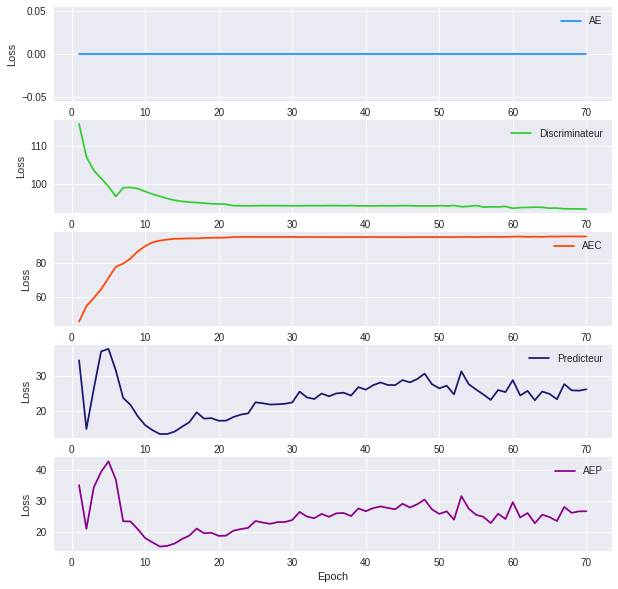

In [0]:
graph_loss(model, ae_losses=ae_losses, d_losses=d_losses, aec_losses=aec_losses, p_losses = p_losses, aep_losses=aep_losses)

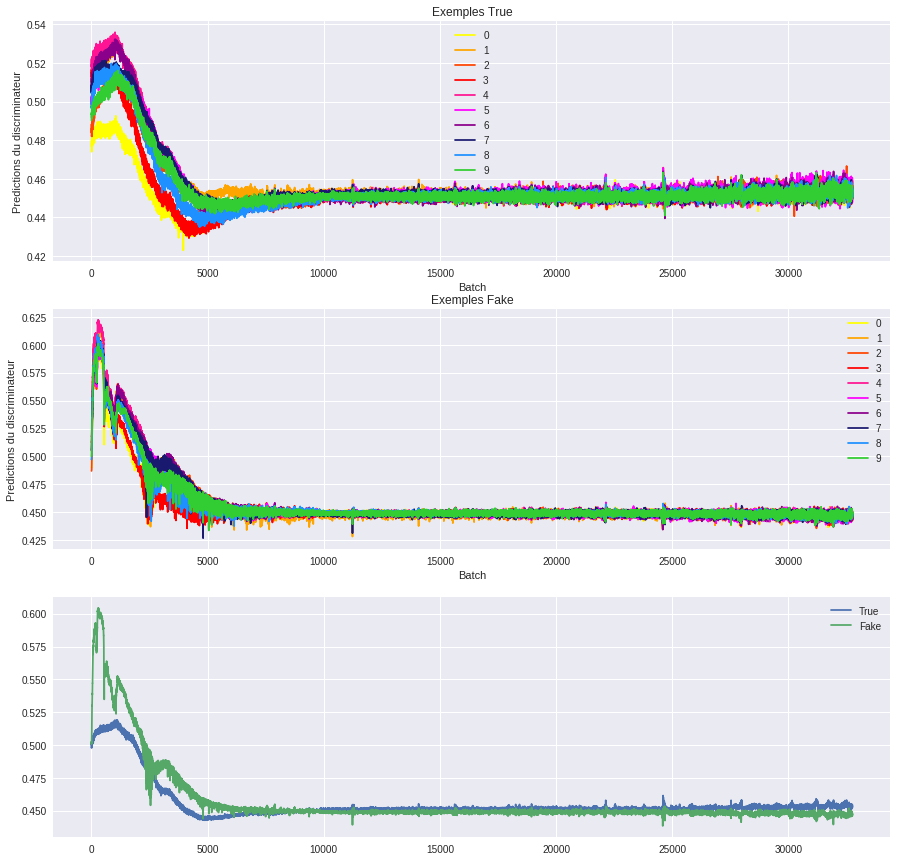

In [0]:
data_discriminator_AECP(data, figsize=(15,15))

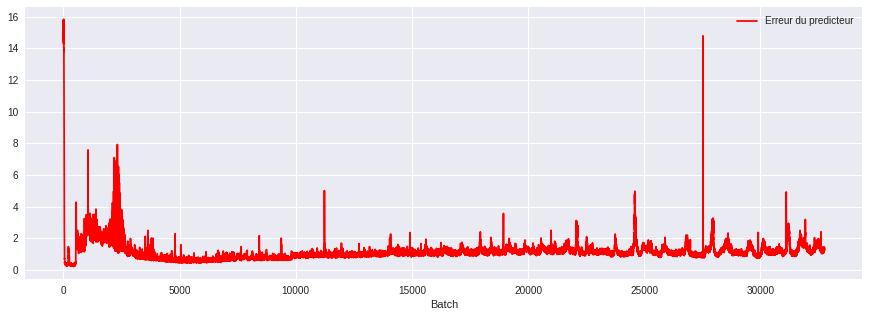

In [0]:
graph_predicteur(data_p, figsize=(15,5))

# Tests

Image d'origine - image generee avec AE - image generee avec variations


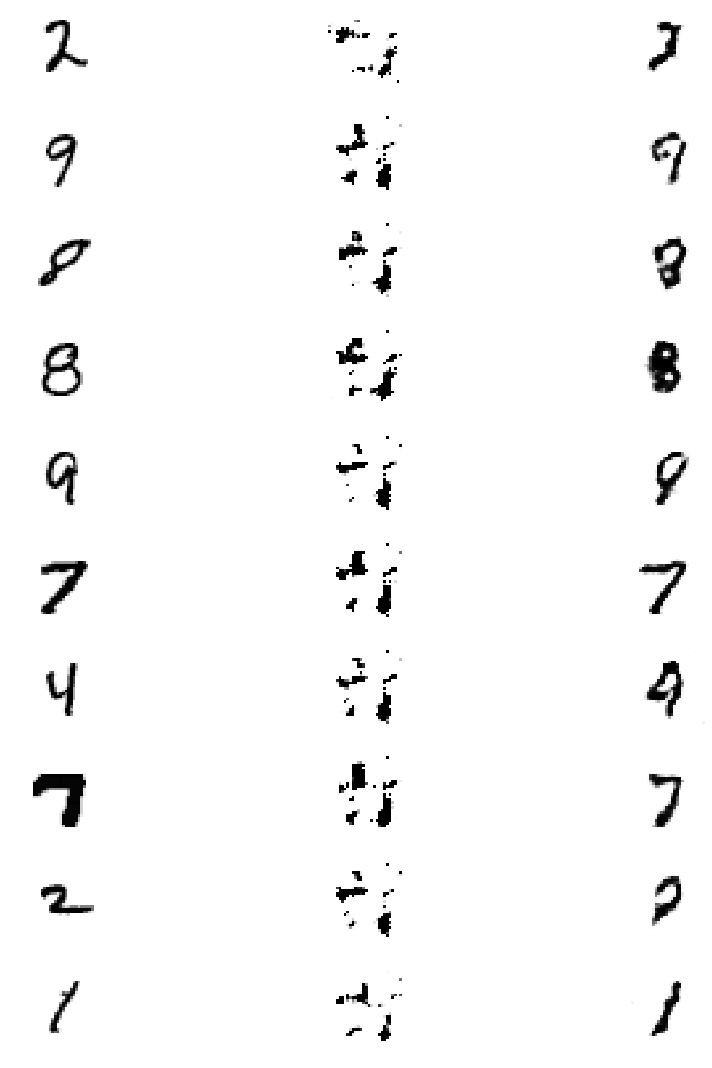

In [0]:
plotGeneratedImages(model, bdd, list_models, examples=10, figsize=(15,15)) #Affichage de 10 couples d'images generees

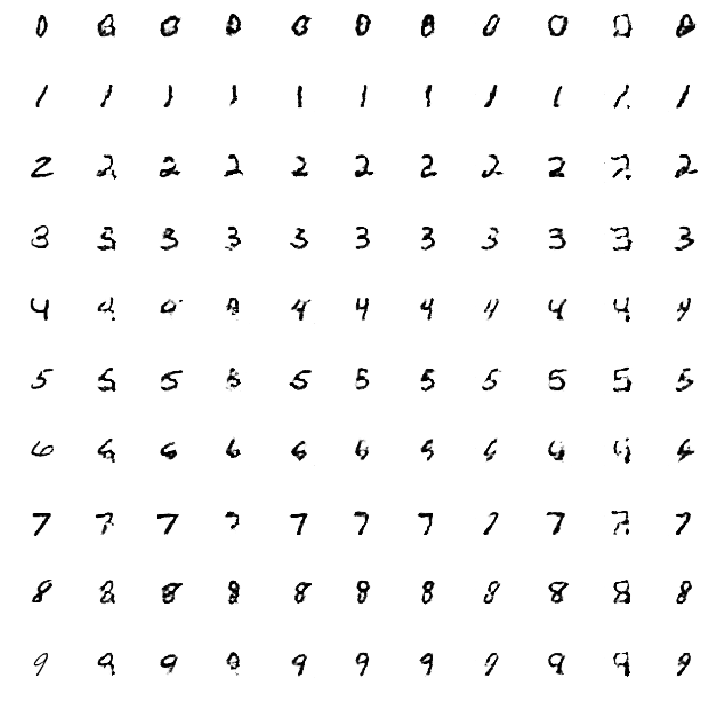

In [0]:
tableau(model, bdd, list_models)

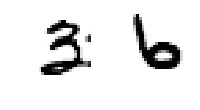

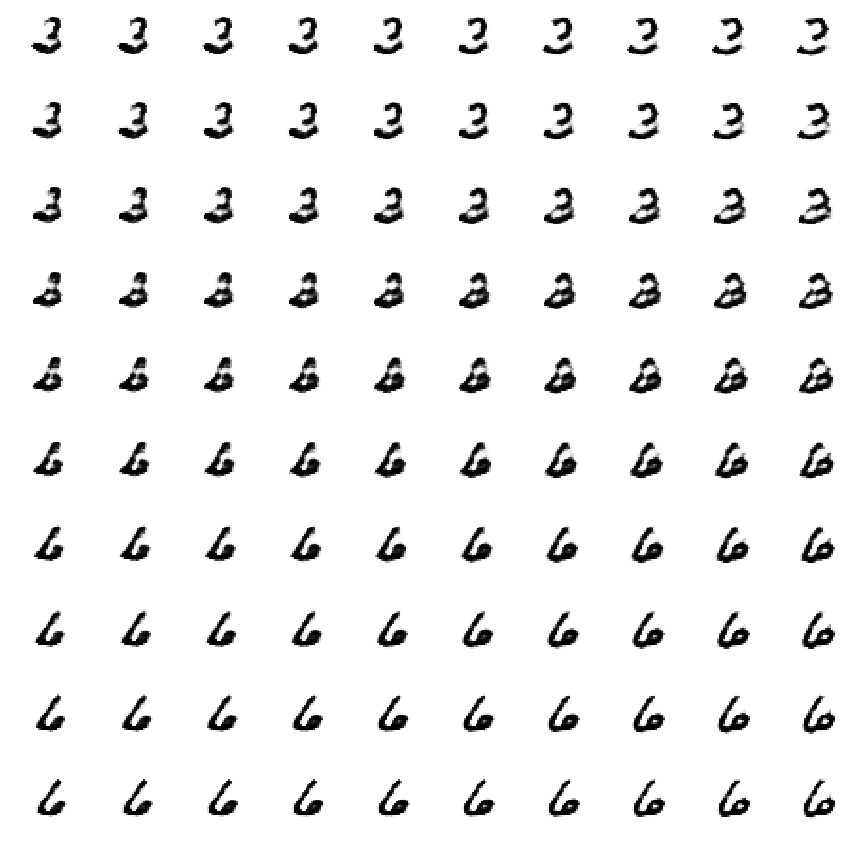

In [0]:
n1 = 3  #premier chiffre
n2 = 6  #deuxieme chiffre

interpolation(model, bdd, list_models, n1, n2, examples=10, figsize=(12,12))

Image d'origine - Image reconstruite 		 Image d'origine - Image reconstruite


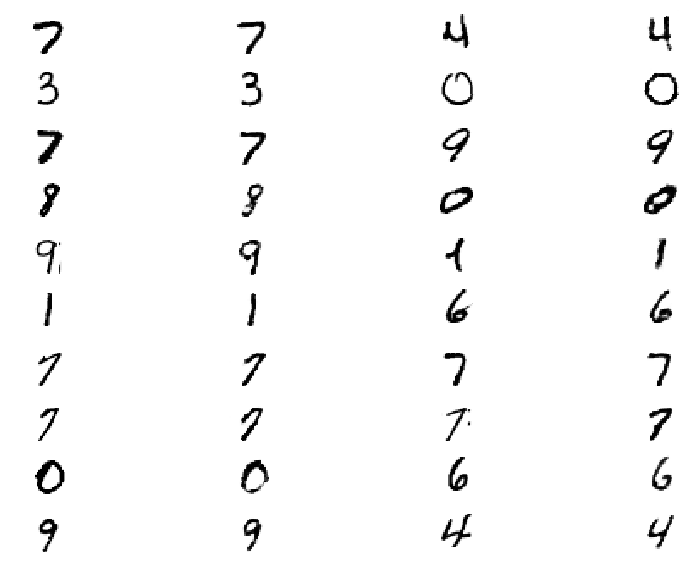

In [0]:
#Test auto-encodeur sans avoir entraine l'AE

examples = 10
indices = np.random.randint(0, len(X_train), size = 2*examples)
img_x = X_train[indices]

encodeur, vector_c, vector_v, generator, discriminator, predicteur, AE, AEC, AEP = list_models

C = vector_c.predict(encodeur.predict(img_x))
V = predicteur.predict(img_x)
img_gen = generator.predict([C,V])
img_x = img_x.reshape((2*examples,28,28))
img_gen = img_gen.reshape((2*examples,28,28))

print("Image d'origine - Image reconstruite \t\t Image d'origine - Image reconstruite")
plt.figure(figsize = (14,examples))
for i in range(examples):
  plt.subplot(examples, 4, 4*i+1)
  plt.imshow(img_x[i])
  plt.axis('off')
  plt.subplot(examples, 4, 4*i+2)
  plt.imshow(img_gen[i])
  plt.axis('off')
  plt.subplot(examples, 4, 4*i+3)
  plt.imshow(img_x[examples+i])
  plt.axis('off')
  plt.subplot(examples, 4, 4*i+4)
  plt.imshow(img_gen[examples+i])
  plt.axis('off')
  
plt.show()